# NI-MVI Semestral project -- ArXiv recommender

## Library installation

In [1]:
!pip install sentence_transformers
# !pip install torch
!pip install umap_learn
# !pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=4fbb4f69c80b88e8aa500476666de487aa3fde55664b3b5648f8733c92338267
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers



## Setup

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# PyTorch
import torch

# Model
from sentence_transformers import SentenceTransformer

# Dimensionality reduction
import umap

# Clustering
# import hdbscan
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load json file as a pandas DataFrame
data = pd.read_json('/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json', lines=True, nrows=10000)

print("Dataset shape:", data.shape)
print("Columns:\n", list(data.columns))

Dataset shape: (10000, 14)
Columns:
 ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


In [4]:
# Keep only categories we are going to use
data = data[["categories", "title", "abstract"]]
print("Dataset shape:", data.shape)

Dataset shape: (10000, 3)


In [5]:
display(data.head())

categories                                              title  \
0           hep-ph  Calculation of prompt diphoton production cros...   
1    math.CO cs.CG           Sparsity-certifying Graph Decompositions   
2   physics.gen-ph  The evolution of the Earth-Moon system based o...   
3          math.CO  A determinant of Stirling cycle numbers counts...   
4  math.CA math.FA  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                            abstract  
0    A fully differential calculation in perturba...  
1    We describe a new algorithm, the $(k,\ell)$-...  
2    The evolution of Earth-Moon system is descri...  
3    We show that a determinant of Stirling cycle...  
4    In this paper we show how to compute the $\L...

## Fine-tuning

In [6]:
# todo

## Text-embedding

In [7]:
# Prepare the SBERT model
model = SentenceTransformer('allenai-specter')

# Move model to gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);

In [8]:
# Encode our sentences (paper abstracts)
embeddings = model.encode(data['abstract'], show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [9]:
embeddings.shape

(10000, 768)

## Clustering

In [10]:
# Reduce dimensionality
umap_embeddings = umap.UMAP(n_neighbors=75, n_components=8, metric='cosine').fit_transform(embeddings)

In [11]:
# Use KMeans to cluster the reduced embeddings
cluster = KMeans(n_clusters=8, random_state=0).fit(umap_embeddings)

# Use HDBSCAN to cluster the reduced embeddings
# cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# Reduce dimensionality to 2 for visualization
umap_data = umap.UMAP(n_neighbors=75, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

## Visualization

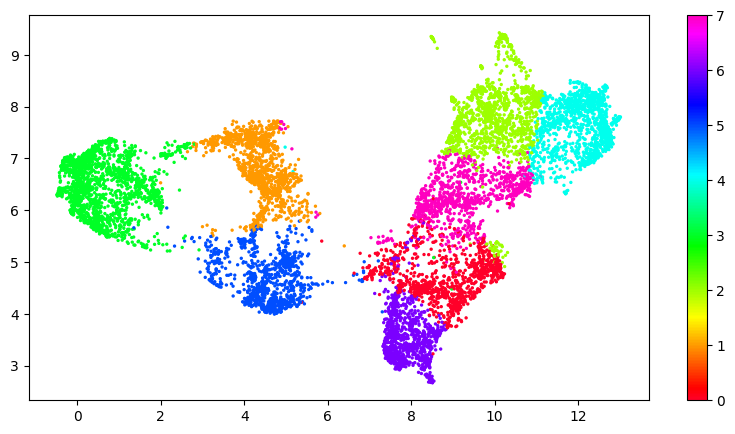

In [19]:
# Prepare data for visualization
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters in 2D
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(result.x, result.y, c=result.labels, s=2, cmap='gist_rainbow');
plt.colorbar();


## Measure performance
To measure the performance of our clustering, we look at the original paper categories. Since the original categories somewhat specific, we truncate them: category.subcategory -> category. This is not perfect, since there is a lot of categories for physics, but for math, there is only one.

For each cluster, we look at the ratio of the cluster size and the amount of datapoints of the most common category. The naive idea of perfect clustering is to have a big cluster for each broad category (in our case: math and the various types of physics), like in the [NeurIPS anthology visualization](https://neuripsav.vizhub.ai/).

In [16]:
# Add clustering results to data
data['labels'] = result['labels']

# Truncate categories for easier interpretation
broad_categories = []
for category in data['categories']:
    first_category = category.split(' ')[0]  # If multiple categories, take first
    broad_category = first_category.split('.')[0]  # Throw away subcategories
    broad_categories.append(broad_category)

data['broad_categories'] = broad_categories

data['broad_categories'] = np.where(data['broad_categories'].str.startswith("hep"), "hep", data['broad_categories'])
data['broad_categories'] = np.where(data['broad_categories'].str.startswith("nucl"), "nucl", data['broad_categories'])

In [17]:
for label in sorted(data['labels'].unique()):
    print(f"label={label}, size={len(data[data['labels'] == label])}")
    print("-------------")
    print(data[data['labels'] == label]['broad_categories'].value_counts().nlargest(3))
    print('\n')
print()

for label in sorted(data['labels'].unique()):
    num_label = len(data[data['labels'] == label])
    num_most_popular = data[data['labels'] == label]['broad_categories'].value_counts()[0]
    print(f"label={label}, {num_most_popular}/{num_label}")


label=0, size=1067
-------------
broad_categories
quant-ph    407
cond-mat    324
physics     203
Name: count, dtype: int64


label=1, size=1217
-------------
broad_categories
hep         748
gr-qc       263
astro-ph     82
Name: count, dtype: int64


label=2, size=1464
-------------
broad_categories
math       484
cs         471
physics    132
Name: count, dtype: int64


label=3, size=1794
-------------
broad_categories
astro-ph    1673
gr-qc         56
physics       49
Name: count, dtype: int64


label=4, size=1336
-------------
broad_categories
math       1214
math-ph      55
hep          26
Name: count, dtype: int64


label=5, size=1027
-------------
broad_categories
hep         708
nucl        231
astro-ph     42
Name: count, dtype: int64


label=6, size=1034
-------------
broad_categories
cond-mat    993
physics      21
quant-ph     13
Name: count, dtype: int64


label=7, size=1061
-------------
broad_categories
cond-mat    355
math        237
physics     163
Name: count, dtype: 

/tmp/ipykernel_47/140657783.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_most_popular = data[data['labels'] == label]['broad_categories'].value_counts()[0]
/tmp/ipykernel_47/140657783.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_most_popular = data[data['labels'] == label]['broad_categories'].value_counts()[0]
/tmp/ipykernel_47/140657783.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_most_popular = 

In [18]:
data['broad_categories'] = np.where(data['broad_categories'].str.startswith("hep"), "hep", data['broad_categories'])
data['broad_categories'] = np.where(data['broad_categories'].str.startswith("nucl"), "nucl", data['broad_categories'])

for c in sorted(data['broad_categories'].unique()):
    print(c)
print()

data['broad_categories'].value_counts()


astro-ph
cond-mat
cs
gr-qc
hep
math
math-ph
nlin
nucl
physics
q-bio
q-fin
quant-ph
stat



broad_categories
math        1953
astro-ph    1838
cond-mat    1756
hep         1564
physics      663
quant-ph     564
cs           492
gr-qc        350
nucl         284
math-ph      202
q-bio        130
nlin         129
q-fin         47
stat          28
Name: count, dtype: int64